# Risk assessment for population exposed to drought

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=Risk_assessment_DROUGHTS_2.ipynb)  [![Droughts](https://img.shields.io/badge/DROUGHTS_GitHub-repository-blue)](https://github.com/CLIMAAX/DROUGHTS/tree/main)

## Preparation

### Load libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:

- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
- [matplotlib](https://matplotlib.org/) - For plotting as well

The data processing in the background also makes use of [dask](https://www.dask.org), but we do not have to import it explicitly.
:::

In [1]:
import os
import pooch

import numpy as np
import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

import pyproj

import matplotlib.colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Create the directory structure

In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure for the in- and output data. If the associated hazard notebook was executed previously, these directories should already exist and are reused here. Nevertheless, do not skip executing these code cells as the `data_dir` variable is used below.

Create a directory called `drought_workflow` in the same directory where this notebook is saved:

In [2]:
workflow_folder = 'simple_drought_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

Create a `data` directory inside the `drought_workflow` folder:

In [3]:
data_dir = os.path.join(workflow_folder,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Data download and exploration

In this workflow we will have a mix of data that is available to download from the notebook, and the data that has to be manually downloaded on the website.

Since there is no API to download this data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to download and unzip it.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

### Region selection

In this workflow we will concentrate on the area of Catalonia, which is roughly between 0°E and 3.4°E longitude and 40.5°N and 42.9°N latitude. If you want to select a different region, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to get the coordinates. Make sure to select ‘CSV’ in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In [4]:
# Longitude in °E
xmin = 0
xmax = 3.4
# Latitude in °N
ymin = 40.5
ymax = 42.9

### Hazard data: Combined Drought Indicator (CDI)

We utilize the Combined Drought Indicator from the European Drought Observatory (EDO) to indicate drought hazard. For more information on this dataset and download options, see the associated hazard workflow. Here, we again download the data for 2022 as an example. Note that pooch will skip the download if the same file was already obtained in the hazard workflow.

In [ ]:
filename = 'cdinx_m_euu_20220101_20221221_t.nc'
url = f'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/DROUGHTOBS/Drought_Observatories_datasets/EDO_Combined_Drought_Indicator/ver3-0-1/{filename}'
known_hash = '7a40b16e5a0cfd53a22ef092f6a8bb511925972c9aaa9913a563c7e8585492e7'

pooch.retrieve(url=url, known_hash=known_hash, path=data_dir, fname=filename)

Open the file for later use:

In [6]:
cdi_nc = xr.open_dataset(f"{data_dir}/cdinx_m_euu_20220101_20221221_t.nc")

Select values of the CDI in early August 2022:

In [7]:
cdi = cdi_nc["cdinx"].sel(time='2022-08-01T00:00:00')

### Exposure data: Population

To assess the risk, we need information on the population living in our region of interest. In this example, we are using population data from [JRC data portal - the Global Human Settlement Layer (GHSL)](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop). Note that this dataset is also available in other resolutions and projections. We are downloading global data here, but it is also available regionally, by clicking on the grid box in the GHSL page.

:::{caution} Attention!
Occasionally there might be difficulties downloading the data programmatically from the JRC server. If the problems persist, try downloading the data manually from the link above.
:::

In [ ]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2020_GLOBE_R2023A_4326_30ss/V1-0/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0.zip'

pooch.retrieve(
    url=url,
    known_hash=None,
    path=data_dir,
    processor=pooch.Unzip(extract_dir='')
)

After downloading and unzipping the data, pooch lists the content of all obtained files. The zip file from the JRC data portal contains data, metadata and documentation (see the included PDF file).

The Population data is in file `GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif`. We can use rioxarray to load this file. Because it is rather big (> 6 GB in memory), we'll also tell xarray to work with the data in smaller *chunks* of 1000 x 1000 data points, which makes the data processing more efficient. 

In [9]:
filename_population = os.path.join(data_dir, "GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0.tif")

population = rxr.open_rasterio(filename_population, chunks={"x": 1000, "y": 1000})
population

<xarray.DataArray (band: 1, y: 21384, x: 43202)> Size: 7GB
dask.array<open_rasterio-d1202e8d7ac567514037b2fb16297768<this-array>, shape=(1, 21384, 43202), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 171kB 89.1 89.09 89.08 ... -89.08 -89.09 -89.1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        277608.74043128
    STATISTICS_MEAN:           8.4874269494672
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         235.7608994699
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

`````{admonition} Information about spatial references, statistics
:class: hint dropdown

👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the information about projection of this dataset.  
👋 Click on **Attributes** to find the STATISTICS attributes including minimum, maximum and other statistics

`````

In the **band** dimension of the array there is only a single entry which we can "squeeze" out:

In [10]:
population = population.squeeze()
population.dims

('y', 'x')

This leaves us with a 2-dimensional array which is ready for plotting.

### Exploring the population data

As stated in the [technical documentation](https://ghsl.jrc.ec.europa.eu/ghs_pop2023.php), each value in the population data corresponds to the number of inhabitants inside the associated cell of the grid (for the example here: 100 x 100 m). We can, e.g., sum over all values to get the total population in the dataset (this can take a few seconds to compute):

In [11]:
total_population = population.sum()

print(f"total population: {int(total_population):,}")

total population: 7,840,952,947


With the bounding box defined above, we select the population in the Catalonia region

In [12]:
catalonia_population = population.sel({
    "x": slice(xmin, xmax),
    "y": slice(ymax, ymin)
})

and create a basic population map:

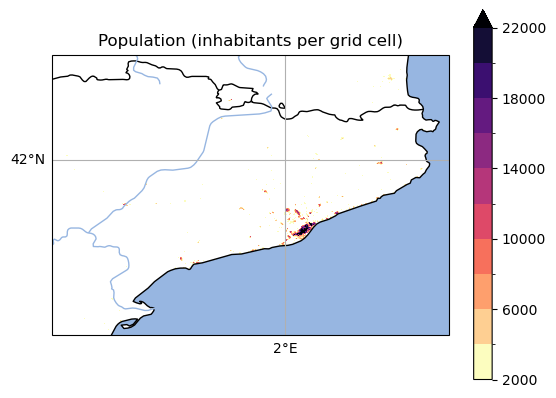

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

catalonia_population.plot.pcolormesh(
    ax=ax,
    cmap="magma_r",
    levels=np.linspace(2000, 22000, 11),
    extend="max",
    transform=ccrs.PlateCarree(),
)

ax.set_title("Population (inhabitants per grid cell)")
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Customize gridlines
gridlines = ax.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
gridlines.top_labels = False
gridlines.right_labels = False

# Add geographical features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.OCEAN);

The city of Barcelona is clearly recognizable by a large number of inhabitants, but other less inhabited population centers are barely or not visible in the map.

One possibility to improve the representation of the less-inhabited places in the map is to plot the population data on a [logarithmic scale](https://en.wikipedia.org/wiki/Logarithmic_scale). We can switch to logarithmic scaling by specifying a `LogNorm` in our plot function:

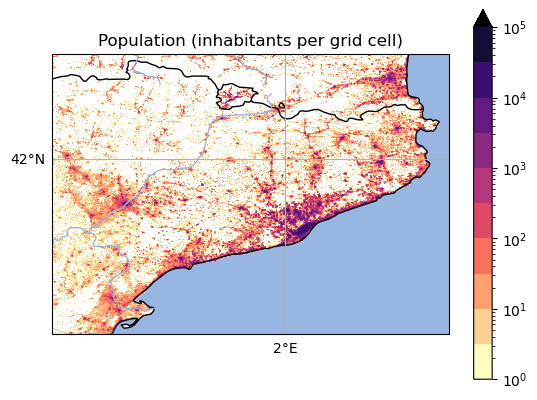

In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

# Plot values on a logarithmic scale across 5 orders of
# magnitude from 1 = 10^0 to 100000 = 10^5
log_norm = matplotlib.colors.LogNorm(vmin=1, vmax=100000)

catalonia_population.plot.pcolormesh(
    ax=ax,
    cmap="magma_r",
    norm=log_norm,
    levels=11,
    extend="max",
    transform=ccrs.PlateCarree()
)

ax.set_title("Population (inhabitants per grid cell)")
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Customize gridlines
gridlines = ax.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
gridlines.top_labels = False
gridlines.right_labels = False

# Add geographical features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.OCEAN);

With the log scale we see more than just Barcelona on the map.

:::{admonition} Caution
:class: warning

Try to keep the logarithmic scaling in mind when interpreting the population data. While the log-scaling gives a better general overview of populated areas, the quantitative relationship between an increase in darkness/intensity of color and number of inhabitants represented by that color is not proportional anymore. Two color levels in the map now represent a *10-fold* increase in the number of inhabitants per grid cell!
:::

`````{admonition} Explore the file contents
:class: tip

Feel free to further explore the content and structure of the datasets. Note the coordinates, dimensions and attributes!
`````

## Data processing and visualization

We want to combine the population and drought data to have a better understanding of which populated areas are affected by drought.

### Transformation into a common coordinate system

The CDI hazard spatial coordinates are named **lon** and **lat**, but have units of meters in a projection coordinate:

In [15]:
cdi.coords["lon"]

<xarray.DataArray 'lon' (lon: 1000)> Size: 8kB
array([2502500, 2507500, 2512500, ..., 7487500, 7492500, 7497500])
Coordinates:
  * lon      (lon) int64 8kB 2502500 2507500 2512500 ... 7487500 7492500 7497500
    time     datetime64[ns] 8B 2022-08-01
Attributes:
    long_name:      projection_x_coordinate
    units:          meters
    standard_name:  projection_x_coordinate
    grid_mapping:   lambert_azimuthal_equal_area

In contrast, the coordinates of the population exposure data are named **x** and **y**, but are specified in degrees longitude and latitude.

In [16]:
catalonia_population.coords["x"]

<xarray.DataArray 'x' (x: 408)> Size: 3kB
array([0.004583, 0.012917, 0.02125 , ..., 3.379583, 3.387917, 3.39625 ])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB 0.004583 0.01292 0.02125 ... 3.38 3.388 3.396
    spatial_ref  int64 8B 0

To combine both datasets, we use the projection information provided in the CDI dataset,

In [17]:
cdi_nc["3035"].proj4_params

'+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000+y_0=3210000 +ellps=GRS80 +units=m +no_defs'

select our region of interest from the CDI dataset in its own projection,

In [18]:
# Obtain projections
xyproj = pyproj.Proj('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs')
latlonproj = pyproj.Proj('epsg:4326')

# Transform bounding box coordinates
transformer = pyproj.Transformer.from_proj(latlonproj, xyproj)
(xmin_xyproj, ymin_xyproj) = transformer.transform(ymin, xmin)
(xmax_xyproj, ymax_xyproj) = transformer.transform(ymax, xmax)

# Extracting data from the projected bounding box
catalonia_cdi = cdi.sel({
    "lat": slice(ymax_xyproj,ymin_xyproj),
    "lon": slice(xmin_xyproj,xmax_xyproj)
})

and then reproject the selected data into a longitude-latitude coordinate system

In [19]:
catalonia_cdi.rio.write_crs(3035, inplace=True)
catalonia_cdi_latlon = catalonia_cdi.rio.reproject("EPSG:4326")

### Combined overview plot

To get a first idea of how the drought indicator and population data overlap, we layer them in a single map plot. As in the associated hazard assessment, we visualize the CDI data by assigning a color to each category and marking affected regions with these colors on the map.

In [20]:
cdi_colors = ["#ffffff", "#f0e442", "#f5aa00", "#dc050c", "#0072b2", "#cc79a7", "#009e73", "#c8c8c8"]
cdi_labels = [
    'No drought',
    'Watch:\n rainfall\n deficit',
    'Warning:\n soil moisture\n deficit',
    'Alert',
    'Recovery',
    'Temporary\n soil moisture\n recovery',
    'Temporary\n fAPAR\n recovery',
    'No data'
]

The population data is layered on top using darkness of color to encode the number of inhabitants per grid cell.

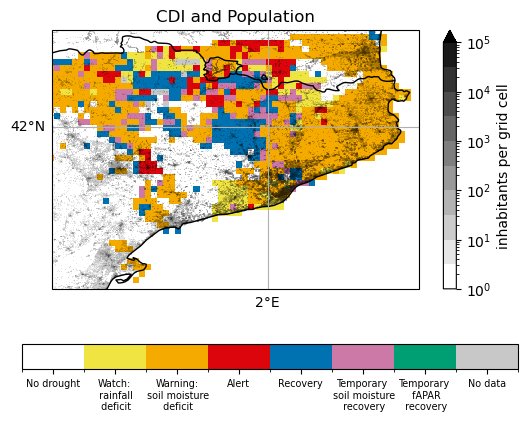

In [21]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

# Add the drought indicator as colored categories
pcm = catalonia_cdi_latlon.plot(
    levels=np.linspace(-0.5, 7.5, len(cdi_colors)+1),
    colors=cdi_colors,
    extend="neither",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "orientation": "horizontal",
        "ticks": np.arange(0, len(cdi_labels)),
        "label": ""
    }
)
pcm.colorbar.set_ticklabels(cdi_labels, fontsize="x-small")

# Layer population data on top by varying lightness of color
catalonia_population.plot.pcolormesh(
    ax=ax,
    cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000", "#000F"]),
    norm=matplotlib.colors.LogNorm(vmin=1, vmax=100000),
    levels=11,
    extend="max",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "label": "inhabitants per grid cell"
    }
)

ax.set_title("CDI and Population")

# Select map region
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
# Customize gridlines
gridlines = ax.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
gridlines.top_labels = False
gridlines.right_labels = False
# Add geographical features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE);

While this gives us a basic idea of how the datasets look together, it is hard to discern information in this somewhat overcrowded map.

### Maps for individual CDI categories

Instead of trying to show everything in one map, we can pick a specific category of the CDI and highlight only the population affected by that category. To implement this, we need to figure out which grid cells in the population dataset belong to which category of the CDI. As can be seen in the overview map, the resolutions of both datasets are different, with the CDI much coarser than the population data. The next step is easiest if we first change the resolution/grid of the CDI to match the resolution/grid of the population.

:::{admonition} Categorical data
:class: caution

Because the CDI values encode categories, we must not interpolate when changing resolution. If we were, e.g., to interpolate between categories 3 (Alert) and 8 (No data), we might obtain a value of 5 (Temporary soil moisture recovery), which is not a meaningful result.
:::

Reindex the CDI dataset to match the population dataset, using a nearest-neighbor method:

In [22]:
cdi_remapped = catalonia_cdi_latlon.reindex_like(catalonia_population, method="nearest")

Create a map where population affected by a given category of the CDI is highlighted in color while other population data is greyed out:

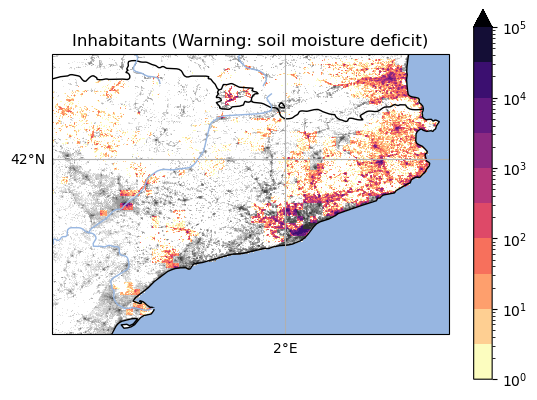

In [23]:
def plot_masked_map(ax, category):
    # Only plot the population data where the given CDI category is found
    xr.where(cdi_remapped == category, catalonia_population, np.nan).plot.pcolormesh(
        ax=ax,
        cmap="magma_r",
        levels=11,
        norm=log_norm,
        extend="max",
        add_colorbar=True,
        transform=ccrs.PlateCarree()
    )
    # Plot all other population data with a greyscale colorbar
    xr.where(cdi_remapped != category, catalonia_population, np.nan).plot.pcolormesh(
        ax=ax,
        cmap="binary",
        levels=11,
        norm=log_norm,
        extend="max",
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    # Add the name of the category
    category_label = cdi_labels[category].replace("\n", "")
    ax.set_title(f"Inhabitants ({category_label})")
    # Select the map region
    ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
    # Customize gridlines
    gridlines = ax.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
    gridlines.top_labels = False
    gridlines.right_labels = False
    # Add geographical features
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.OCEAN)

# Use the function above to create a map plot for a specific CDI category,
# identified by its numeric value in the CDI dataset (0-7)
fig, ax = plt.subplots(1, 1, subplot_kw={ "projection": ccrs.PlateCarree() })
plot_masked_map(ax, category=2)

Use the function to produce maps for all categories:

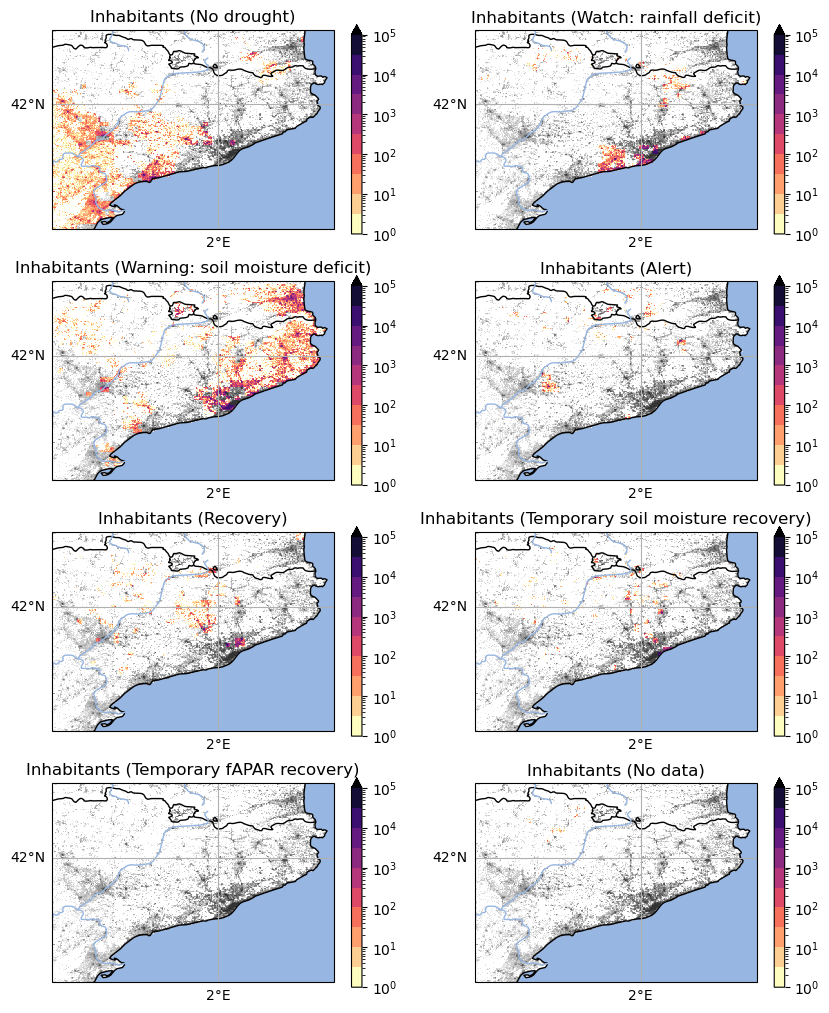

In [24]:
fig, axs = plt.subplots(4, 2, figsize=(10, 12.5), subplot_kw={"projection": ccrs.PlateCarree()})

for category, ax in enumerate(axs.flatten()):
    plot_masked_map(ax, category)

# Save a copy of this plot in the workflow folder
fig.savefig(os.path.join(workflow_folder, "population_by_CDI_maps.png"))

### Total affected population

Finally, to get a specific quantitative assessment of the drought-affected population, sum the inhabitants per grid cell for each category in the region defined by the bounding box and covered by the dataset:

In [25]:
affected_pop = [
    xr.where(cdi_remapped == category, catalonia_population, np.nan).sum().values
    for category in range(len(cdi_labels))
]

Create a bar chart that shows the aggregated population per category:

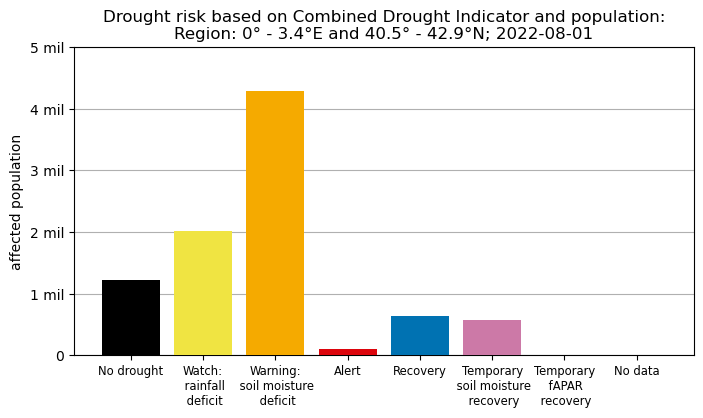

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_title(
    "Drought risk based on Combined Drought Indicator and population:\n"
    f"Region: {xmin}° - {xmax}°E and {ymin}° - {ymax}°N; {cdi.time.dt.date.values}"
)

# Change "No drought" from white to black
cdi_colors[0] = "#000000"

# Bar plot with population value for each category
x = np.arange(len(affected_pop))
ax.bar(x, affected_pop, color=cdi_colors, zorder=3)

# Add horizontal gridlines behind bar chart
ax.grid(axis="y", zorder=0)
# Label the categories
ax.set_xticks(x, cdi_labels, fontsize="small")
# Label the population axis (y)
ax.set_yticks([0, 1e6, 2e6, 3e6, 4e6, 5e6], ["0", "1 mil", "2 mil", "3 mil", "4 mil", "5 mil"])
ax.set_ylabel("affected population")

# Save a copy of this plot in the workflow folder
fig.savefig(os.path.join(workflow_folder, "population_by_CDI_agg.png"))

## Conclusions

In this workflow, we have seen how to combine a drought indicator with population data to identify regions where the population is exposed to drought and quantify how many people are affected.

## Contributors

- Milana Vuckovic, ECMWF
- Maurizio Mazzoleni, Vrije Universiteit Amsterdam
- Christopher Polster, ECMWF